In [32]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from tqdm import tqdm
from glob import glob
import gc


import cv2
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['axes.titlesize'] = 16

import pydicom as dicom

import warnings
warnings.filterwarnings('ignore')

#print(os.listdir('/kaggle/input/'))

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

2021-03-15 17:25:16.226777


In [34]:
base_dir = ''
#os.listdir(base_dir)
train = pd.read_csv(base_dir + 'train.csv')
train

image_id          class_name  class_id rad_id  \
0      50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1      21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2      9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3      051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4      063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
...                                 ...                 ...       ...    ...   
67909  936fd5cff1c058d39817a08f58b72cae          No finding        14     R1   
67910  ca7e72954550eeb610fe22bf0244b7fa          No finding        14     R1   
67911  aa17d5312a0fb4a2939436abca7f9579          No finding        14     R8   
67912  4b56bc6d22b192f075f13231419dfcc8        Cardiomegaly         3     R8   
67913  5e272e3adbdaafb07a7e84a9e62b1a4c          No finding        14    R16   

        x_min   y_min   x_max   y_max  
0         NaN     NaN     NaN     NaN  
1         NaN     NaN     NaN     NaN  
2       691.0  1375.0  1653.0  1831.0  
3      1264.0   743.0  1611.0  1019.0  
4         NaN     NaN     NaN     NaN  
...       ...     ...     ...     ...  
67909     NaN     NaN     NaN     NaN  
67910     NaN     NaN     NaN     NaN  
67911     NaN     NaN     NaN     NaN  
67912   771.0   979.0  1680.0  1311.0  
67913     NaN     NaN     NaN     NaN  

[67914 rows x 8 columns]

In [35]:
sub = pd.read_csv(base_dir + 'validation.csv')
sub

image_id             PredictionString
0     9f709e4b36665cf43eabf6fbe7e014ce               14 1.0 0 0 1 1
1     aff3ad83a6b6a86cb6ff098d920b2da9               14 1.0 0 0 1 1
2     ad413beaa010e38e1f06dad791e3c81c               14 1.0 0 0 1 1
3     81b84cb547ada6c0a05c8c6dea989b31               14 1.0 0 0 1 1
4     0f48cb3124f7e8c3a849f120c36dcda5  0 0.6595 1063 807 1302 1058
...                                ...                          ...
2995  7c0ddf911bdb68fca14d7172486827cb               14 1.0 0 0 1 1
2996  209e3a5c73c1195d805dd25d086b3c6d               14 1.0 0 0 1 1
2997  1bea772246421c37929f8cbc43dba729               14 1.0 0 0 1 1
2998  ae86eabab95525b41b8e79883ff1cef9               14 1.0 0 0 1 1
2999  839b2311ffad9bdd9aa98c74aad6e251               14 1.0 0 0 1 1

[3000 rows x 2 columns]

In [36]:
print('Number of train image ids: {}'.format(len(train)))
print('Number of test image ids: {}'.format(len(sub)))
print('Number of unique train image ids: {}'.format(train['image_id'].nunique()))
print('Number of unique test image ids: {}'.format(sub['image_id'].nunique()))
print('Number of unique rad id in train: {}'.format(train['rad_id'].nunique()))
print('Number of targets: {}'.format(train['class_name'].nunique()))
targets = np.sort(train['class_name'].unique())
print(targets)
train['class_name'].value_counts(normalize = True)

Number of train image ids: 67914
Number of test image ids: 3000
Number of unique train image ids: 15000
Number of unique test image ids: 3000
Number of unique rad id in train: 17
Number of targets: 15
['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Consolidation' 'ILD' 'Infiltration' 'Lung Opacity' 'No finding'
 'Nodule/Mass' 'Other lesion' 'Pleural effusion' 'Pleural thickening'
 'Pneumothorax' 'Pulmonary fibrosis']


No finding            0.468504
Aortic enlargement    0.105457
Cardiomegaly          0.079910
Pleural thickening    0.071296
Pulmonary fibrosis    0.068543
Nodule/Mass           0.037989
Lung Opacity          0.036561
Pleural effusion      0.036458
Other lesion          0.032438
Infiltration          0.018361
ILD                   0.014725
Calcification         0.014136
Consolidation         0.008187
Atelectasis           0.004108
Pneumothorax          0.003328
Name: class_name, dtype: float64

In [37]:
target_map = {'Aortic enlargement': 0, 'Atelectasis': 1, 'Calcification': 2, 'Cardiomegaly': 3, 
              'Consolidation': 4,  'ILD': 5, 'Infiltration': 6, 'Lung Opacity': 7, 'Nodule/Mass': 8, 
              'Other lesion': 9, 'Pleural effusion': 10, 'Pleural thickening': 11, 'Pneumothorax': 12, 
              'Pulmonary fibrosis': 13, ' No finding': 14}

In [38]:
print('Read and display a dicom file...')

img_id = np.random.choice(train['image_id'], 1)[0]
dicom_path = base_dir + 'train/' + img_id + '.dicom'
dicom_img = dicom.dcmread(dicom_path)
print(dicom_img)

Read and display a dicom file...
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 5170326726acc5b2f50c4426417f3b23
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '055Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2678
(0028, 0011) Columns                             US

In [39]:
idx = np.random.choice(train['image_id'], 1)[0]
cls = train.loc[train['image_id'] == idx, 'class_name']
print('Number of classes for image id: {} is {}'.format(idx, len(cls)))
print('Number of unique classes for image id: {} is {}'.format(idx, len(np.unique(cls))))
print(cls)

Number of classes for image id: e553a378133c655abbda6a0b64b3077e is 11
Number of unique classes for image id: e553a378133c655abbda6a0b64b3077e is 4
14025    Pleural thickening
15306    Pleural thickening
19181    Pulmonary fibrosis
19558    Pulmonary fibrosis
25829    Pulmonary fibrosis
26850    Pulmonary fibrosis
27696         Consolidation
37550    Pulmonary fibrosis
37584          Infiltration
41562          Infiltration
54789    Pulmonary fibrosis
Name: class_name, dtype: object


In [49]:
def display_all_class(idx, lbl):
    f, ax = plt.subplots(1, 3, figsize = (15, 10))
    f.subplots_adjust(hspace = .1, wspace = .1)

    for i in range(3):
        dicom_path = base_dir + 'train/' + idx[i] + '.dicom'
        temp = train.loc[train['image_id'] == idx[i]]
        n_diag = len(temp)
        n_udiag = temp['class_name'].unique()
        #cmap = plt.cm.get_cmap("hsv", n_diag + 1)
        dicom_file = dicom.dcmread(dicom_path)
        img = dicom_file.pixel_array
        ax[i].imshow(img, cmap = 'gray')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].set_title(f'{lbl}, Votes: {n_diag}, Majority: {len(n_udiag)}', fontsize = 10)
        if lbl != 'No finding':
            for j in temp.index.values:
                bbox = [temp.loc[j, 'x_min'],
                        temp.loc[j, 'y_min'],
                        temp.loc[j, 'x_max'],
                        temp.loc[j, 'y_max']]
                print(bbox)
                p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                                 bbox[2] - bbox[0],
                                                 bbox[3] - bbox[1],
                                                 ec = np.random.random(3), fc = 'none')
                ax[i].add_patch(p)
    plt.show()

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Aortic enlargement


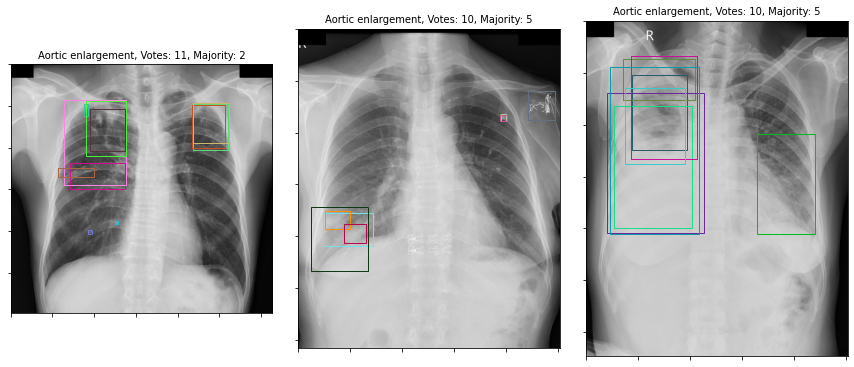

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Atelectasis


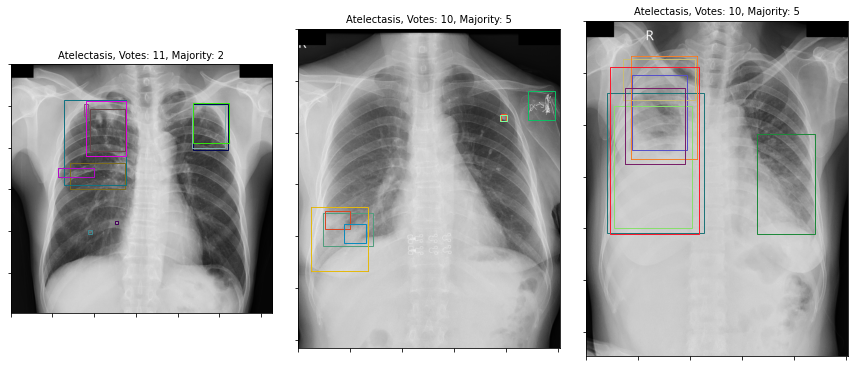

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Calcification


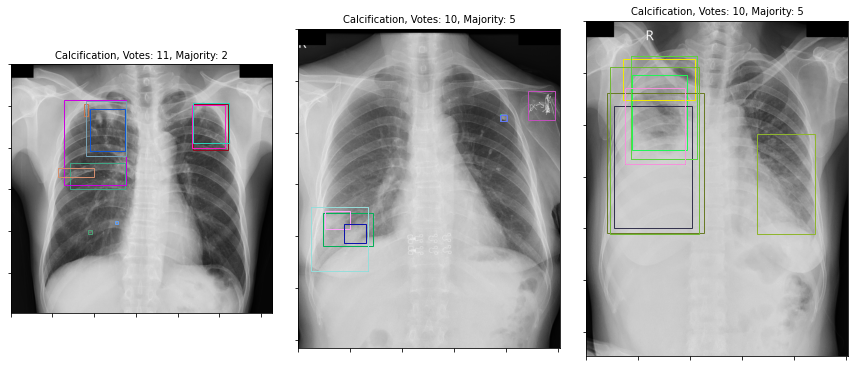

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Cardiomegaly


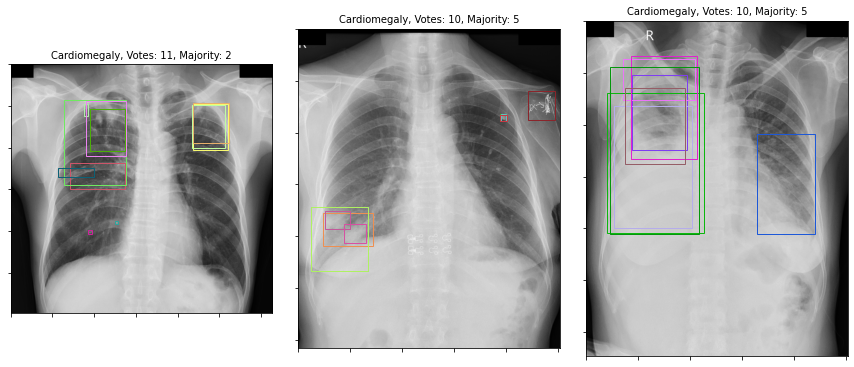

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Consolidation


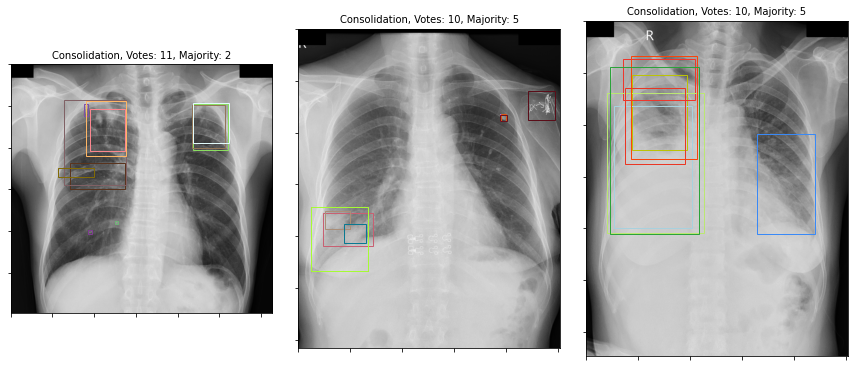

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
ILD


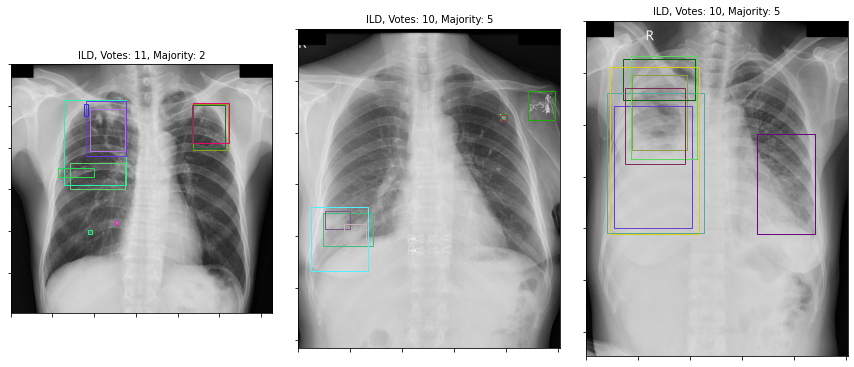

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Infiltration


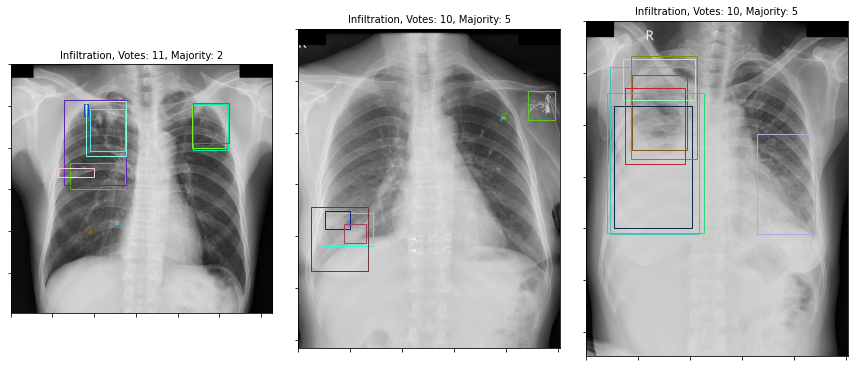

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Lung Opacity


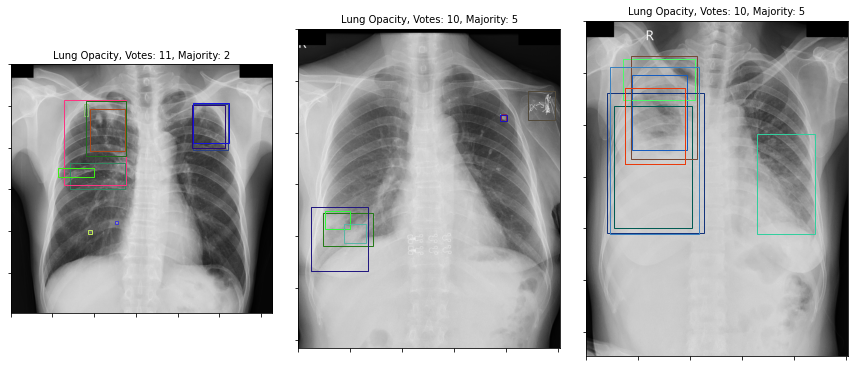

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
No finding


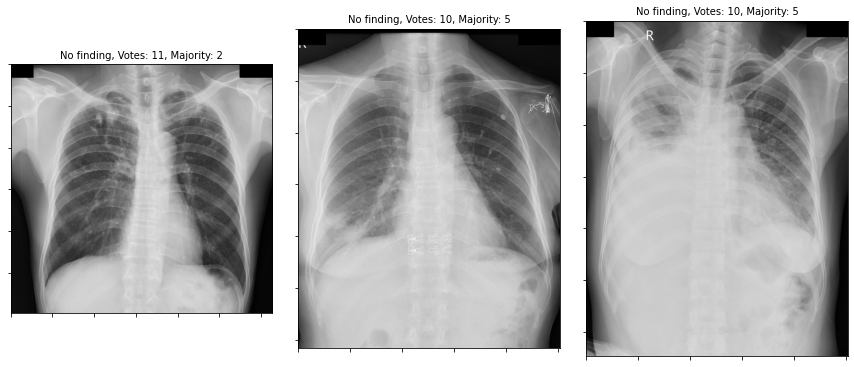

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Nodule/Mass


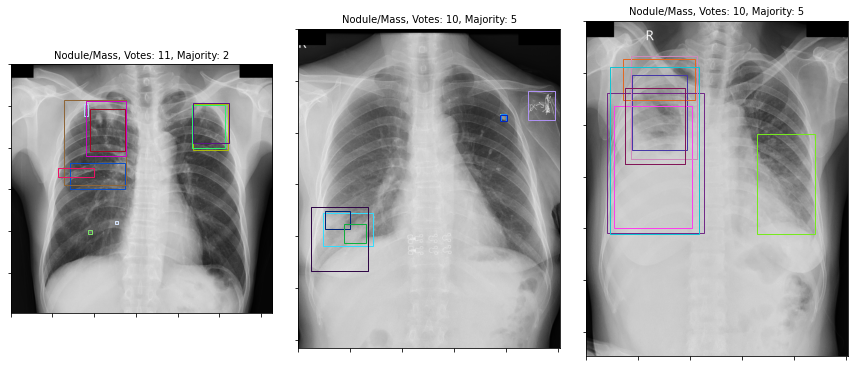

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Other lesion


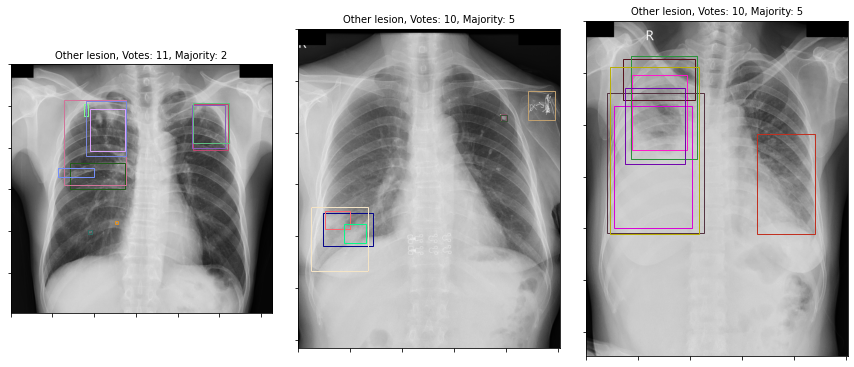

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Pleural effusion


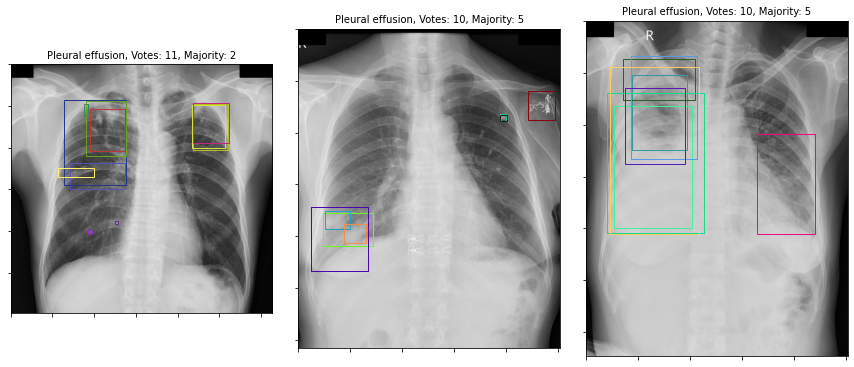

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Pleural thickening


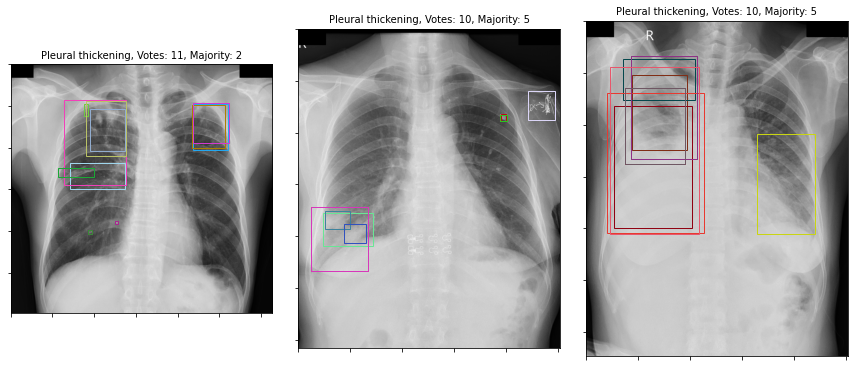

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Pneumothorax


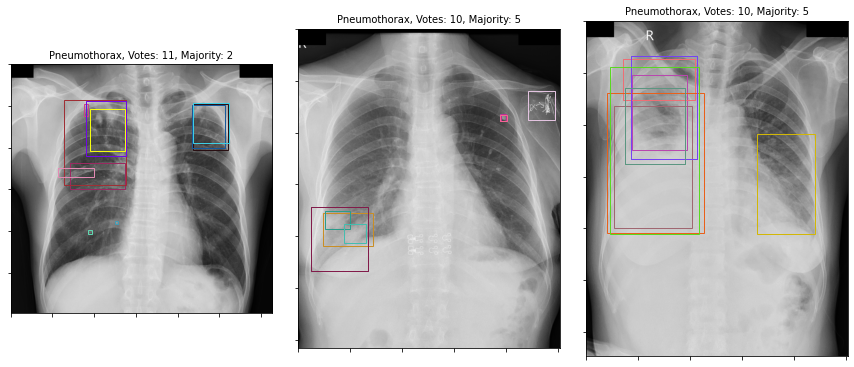

['4652edceea12613caef68322a7fddec0', '5562ea946b0ed8574dd20d05a001d6c4', '5938d1edca572c6168c83190a35b4504']
Pulmonary fibrosis


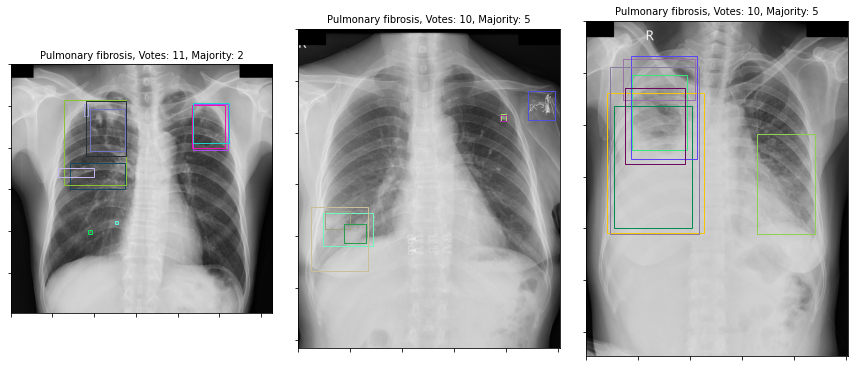

In [47]:
for i, lbl in enumerate(targets):
    #ids = train.loc[train['class_name'] == lbl]['image_id'].unique()[:3]
    ids = ['4652edceea12613caef68322a7fddec0','5562ea946b0ed8574dd20d05a001d6c4','5938d1edca572c6168c83190a35b4504']
    print(ids)
    print(lbl)
    display_all_class(ids, lbl)

[927.0, 1981.0, 974.0, 2032.0]
[2180.0, 471.0, 2605.0, 1031.0]
[2171.0, 485.0, 2564.0, 1009.0]
[709.0, 1187.0, 1371.0, 1497.0]
[634.0, 431.0, 1378.0, 1446.0]
[561.0, 1246.0, 995.0, 1353.0]
[945.0, 536.0, 1371.0, 1042.0]
[2190.0, 458.0, 2621.0, 943.0]
[880.0, 473.0, 923.0, 621.0]
[1244.0, 1883.0, 1291.0, 1916.0]
[897.0, 437.0, 1381.0, 1094.0]
[1954.0, 823.0, 1999.0, 890.0]
[124.0, 1722.0, 670.0, 2339.0]
[241.0, 1775.0, 716.0, 2089.0]
[124.0, 1722.0, 670.0, 2339.0]
[1942.0, 822.0, 2002.0, 887.0]
[2217.0, 604.0, 2469.0, 876.0]
[260.0, 1758.0, 495.0, 1932.0]
[441.0, 1884.0, 647.0, 2064.0]
[1954.0, 823.0, 1999.0, 890.0]
[1944.0, 828.0, 2008.0, 889.0]
[439.0, 521.0, 973.0, 1243.0]
[359.0, 364.0, 1046.0, 764.0]
[378.0, 647.0, 956.0, 1380.0]
[264.0, 817.0, 1022.0, 1993.0]
[435.0, 334.0, 1071.0, 1327.0]
[198.0, 699.0, 1133.0, 2042.0]
[435.0, 334.0, 1071.0, 1327.0]
[378.0, 647.0, 956.0, 1380.0]
[227.0, 441.0, 1088.0, 2057.0]
[1645.0, 1088.0, 2200.0, 2050.0]


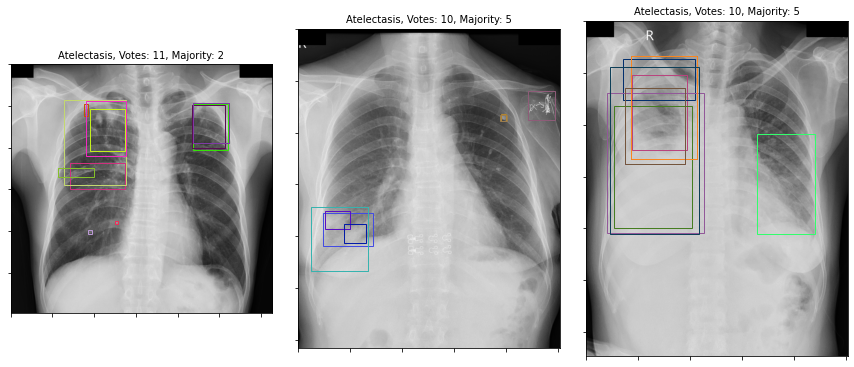

In [50]:
ids = ['4652edceea12613caef68322a7fddec0','5562ea946b0ed8574dd20d05a001d6c4','5938d1edca572c6168c83190a35b4504']
display_all_class(ids, targets[1])

In [63]:
def display_valid_class(idx, lbl,positionlist):
    f, ax = plt.subplots(1, 3, figsize = (15, 10))
    f.subplots_adjust(hspace = .1, wspace = .1)

    for i in range(3):
        dicom_path = base_dir + 'train/' + idx[i] + '.dicom'
        temp = sub.loc[sub['image_id'] == idx[i]]
        #n_diag = len(temp)
        #n_udiag = temp['class_name'].unique()
        #cmap = plt.cm.get_cmap("hsv", n_diag + 1)
        dicom_file = dicom.dcmread(dicom_path)
        img = dicom_file.pixel_array
        ax[i].imshow(img, cmap = 'gray')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        #ax[i].set_title(f'{lbl}, Votes: {n_diag}, Majority: {len(n_udiag)}', fontsize = 10)
        if lbl != 'No finding':
            count=0
            for j in range(5):
                bbox = [positionlist[j+4*count],
                        positionlist[1+j+4*count],
                        positionlist[2+j+4*count],
                        positionlist[3+j+4*count]]
                print(bbox)
                p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                                 bbox[2] - bbox[0],
                                                 bbox[3] - bbox[1],
                                                 ec = np.random.random(3), fc = 'none')
                ax[i].add_patch(p)
                count=count+1
    plt.show()

In [64]:
list1=[2178, 634, 2556, 1026, 2054, 484, 2570, 1071,952, 474, 1324, 947, 2290, 778, 2538, 983, 1693, 801, 1989, 1159,1978, 437, 2421, 830]

[2178, 634, 2556, 1026]
[484, 2570, 1071, 952]
[1324, 947, 2290, 778]
[983, 1693, 801, 1989]
[1978, 437, 2421, 830]
[2178, 634, 2556, 1026]
[484, 2570, 1071, 952]
[1324, 947, 2290, 778]
[983, 1693, 801, 1989]
[1978, 437, 2421, 830]
[2178, 634, 2556, 1026]
[484, 2570, 1071, 952]
[1324, 947, 2290, 778]
[983, 1693, 801, 1989]
[1978, 437, 2421, 830]


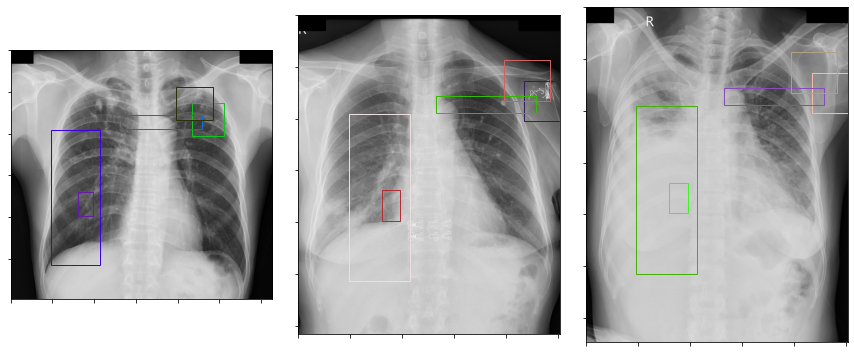

In [65]:
ids = ['4652edceea12613caef68322a7fddec0','5562ea946b0ed8574dd20d05a001d6c4','5938d1edca572c6168c83190a35b4504']
display_valid_class(ids, targets[1],list1)

In [66]:
list2 =[1260, 826, 1555, 1151,  895, 1705, 2007, 2125, 1945, 828, 2001, 881,  1894, 1328, 1955, 1383,  223, 1746, 522 ,2020, 276, 1786, 695, 2105,]

[1260, 826, 1555, 1151]
[1705, 2007, 2125, 1945]
[2001, 881, 1894, 1328]
[1383, 223, 1746, 522]
[276, 1786, 695, 2105]
[1260, 826, 1555, 1151]
[1705, 2007, 2125, 1945]
[2001, 881, 1894, 1328]
[1383, 223, 1746, 522]
[276, 1786, 695, 2105]
[1260, 826, 1555, 1151]
[1705, 2007, 2125, 1945]
[2001, 881, 1894, 1328]
[1383, 223, 1746, 522]
[276, 1786, 695, 2105]


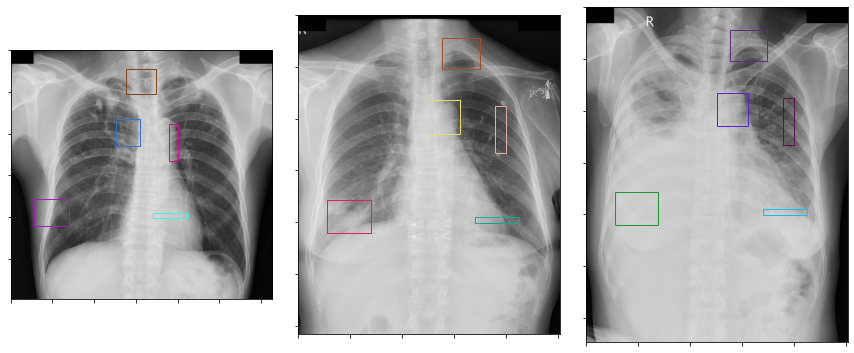

In [68]:
ids = ['4652edceea12613caef68322a7fddec0','5562ea946b0ed8574dd20d05a001d6c4','5938d1edca572c6168c83190a35b4504']
display_valid_class(ids, targets[1],list2)